In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
#import bambi as bmb
import xarray as xr
import random
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('paper')
sns.set_style('ticks')
plt.rc("axes.spines", top=False, right=False)
with matplotlib.style.context('arviz-doc'):
    az_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
sns.set_palette(az_colors)

def origo(ax=None):
    if ax is None:
        ax = plt.gca()
    x, y = ax.get_xlim(), ax.get_ylim()
    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    plt.ylim(min(0, miny), max(0, maxy))
    plt.xlim(min(0, minx), max(0, maxx))

class columns:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)
        

In [2]:
# scale = 0.35
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context().items() if v is not None])
# d['figure.figsize'] = [1.8, 1.3]
# matplotlib.rcParams.update(d)
# make context for with statement:
# #matplotlib.style.context(d)

In [3]:
# plt.plot(np.random.random(10), np.random.random(10)-10)
# origo()

In [4]:
#Disable annoying "UserWarning: The figure layout has changed to tight" message
import warnings
warnings.filterwarnings('ignore', category=UserWarning
                        # , module='seaborn'
                       )
warnings.filterwarnings('ignore', category=FutureWarning,
                        # module='matplotlib'
                       )

# Model comparison

Turn HDF5 Series back into arviz `ELPDData`:

In [5]:
from arviz.stats import ELPDData
loo_hierarchical = ELPDData(pd.read_hdf('loo_hierarchical.h5'))
loo_parallel = ELPDData(pd.read_hdf('loo_parallel.h5'))

ArviZ includes two convenience functions to help compare LOO for different models. The first of these functions is compare, which computes LOO (or WAIC) from a set of traces and models and returns a DataFrame.

In [6]:
# these should ofcaues be different models...
loo_compare = az.compare({"hierarchical": loo_hierarchical, 
                          "parallel": loo_parallel})
loo_compare

/home/kmt/miniconda3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:251: RuntimeWarning: divide by zero encountered in log
  score += np.log(np.dot(exp_ic_i[i], w_full))
/home/kmt/miniconda3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:258: RuntimeWarning: invalid value encountered in scalar divide
  grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.dot(exp_ic_i[i], w_full)


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
parallel,0,-4.122799e+06,287.252091,0.000000,0.5,5102.466260,0.000000,True,log
hierarchical,1,-4.122802e+06,286.866370,3.235702,0.5,5102.074891,2.620337,True,log


We have many columns, so let’s check out their meaning one by one:

1. The index is the names of the models taken from the keys of the dictionary passed to compare(.).
2. rank, the ranking of the models starting from 0 (best model) to the number of models.
3. loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.
4. p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).
5. d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.
6. weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.
se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.
7. dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.
8. warning, If True the computation of LOO/WAIC may not be reliable.
9. loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

The second convenience function takes the output of compare and produces a summary plot in the style of the one used in the book Statistical Rethinking by Richard McElreath (check also this port of the examples in the book to PyMC).

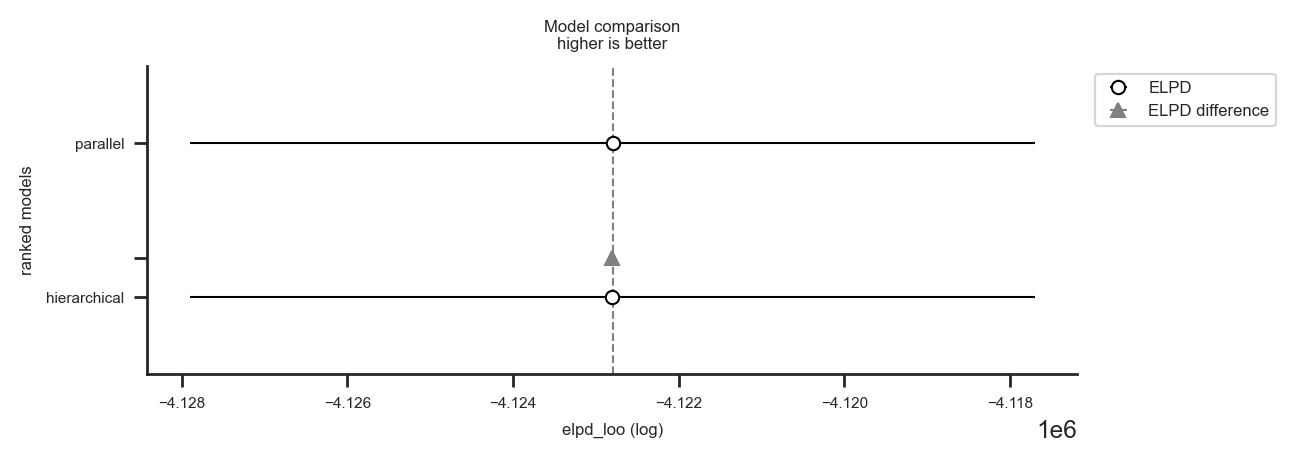

In [7]:
az.plot_compare(loo_compare, insample_dev=False);

The empty circle represents the values of LOO and the black error bars associated with them are the values of the standard deviation of LOO.

The value of the highest LOO, i.e the best estimated model, is also indicated with a vertical dashed grey line to ease comparison with other LOO values.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey error bar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

**Interpretation**

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, given that both models gives very similar values of the information criteria. This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of LOO and WAIC.

[https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html)

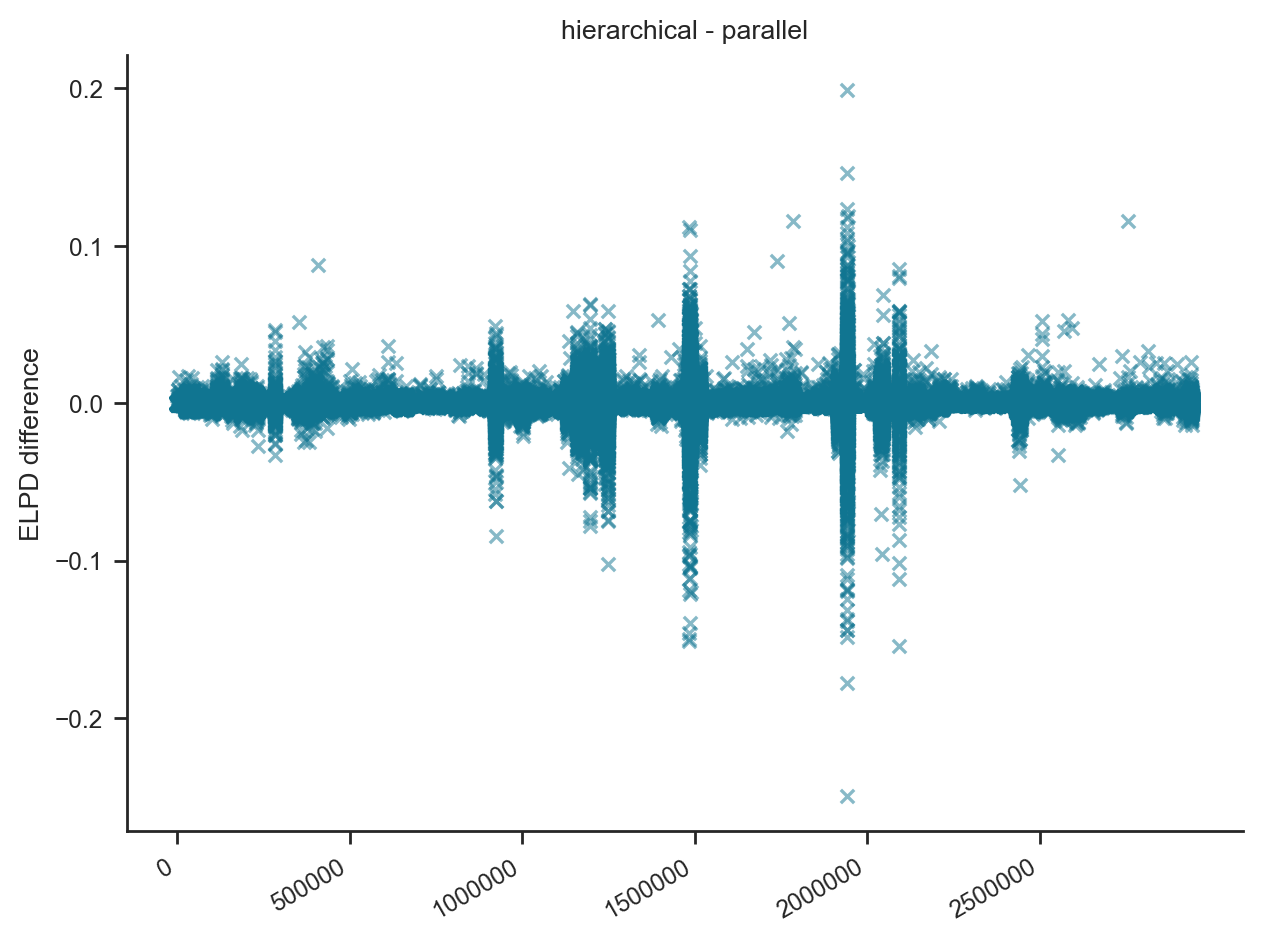

In [18]:
az.plot_elpd(
    {"hierarchical": loo_hierarchical, 
     "parallel": loo_parallel},
    xlabels=True,
    plot_kwargs=dict(marker='x', alpha=0.5)
) ;

In [19]:
# groups = loo_hierarchical.posterior.global_group[loo_hierarchical.constant_data.global_group_member].values
# colors = [f"C{i % 10}" for (i, gr) in enumerate(groups)]

In [14]:
loo_hierarchical.loo_i

<xarray.DataArray 'loo_i' (obs_id: 2940166)> Size: 24MB
array([-0.92420078, -0.90324919, -1.26871918, ..., -1.43984325,
       -1.04168463, -1.5734164 ])
Coordinates:
  * obs_id   (obs_id) int64 24MB 0 1 2 3 4 ... 2940162 2940163 2940164 2940165